In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from collections import Counter, defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import random
import math

import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm
import time

In [2]:
# Load interaction splits
train_df = pd.read_csv("dataset/interactions_train.csv")
val_df = pd.read_csv("dataset/interactions_validation.csv")
test_df = pd.read_csv("dataset/interactions_test.csv")

# Optional: load raw metadata for future use
raw_recipes = pd.read_csv("dataset/RAW_recipes.csv")
raw_interactions = pd.read_csv("dataset/RAW_interactions.csv")

# Preprocessed embeddings (not needed yet)
pp_users = pd.read_csv("dataset/PP_users.csv")
pp_recipes = pd.read_csv("dataset/PP_recipes.csv")

# Exploratory Data Analysis

## Interaction Data

In [3]:
train_df.head()

,user_id,recipe_id,date,rating,u,i
0,2046,4684,2000-02-25,5.0,22095,44367
1,2046,517,2000-02-25,5.0,22095,87844
2,1773,7435,2000-03-13,5.0,24732,138181
3,1773,278,2000-03-13,4.0,24732,93054
4,2046,3431,2000-04-07,5.0,22095,101723


In [4]:
train_df.info()
train_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698901 entries, 0 to 698900
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    698901 non-null  int64  
 1   recipe_id  698901 non-null  int64  
 2   date       698901 non-null  object 
 3   rating     698901 non-null  float64
 4   u          698901 non-null  int64  
 5   i          698901 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 32.0+ MB


,user_id,recipe_id,rating,u,i
count,6.989010e+05,698901.000000,698901.000000,698901.000000,698901.000000
mean,1.247694e+07,156173.409849,4.574090,4249.330271,87519.330993
std,1.525031e+08,126594.880211,0.959022,5522.602821,51290.370370
min,1.533000e+03,38.000000,0.000000,0.000000,0.000000
25%,1.059880e+05,53169.000000,4.000000,455.000000,42988.000000
50%,2.301020e+05,116484.000000,5.000000,1737.000000,87424.000000
75%,4.801950e+05,234516.000000,5.000000,5919.000000,131731.000000
max,2.002313e+09,537458.000000,5.000000,25075.000000,178262.000000


### Distribution of Recipe Ratings

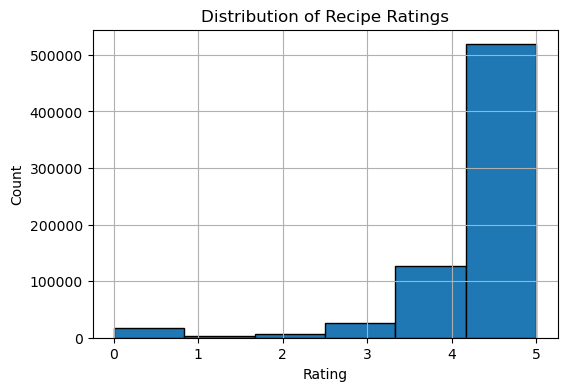

In [5]:
plt.figure(figsize=(6,4))
train_df['rating'].hist(bins=6, edgecolor='black')
plt.title("Distribution of Recipe Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

The distribution of ratings in the dataset is heavily skewed toward the positive end of the scale. Ratings of 4 and 5 stars dominate the dataset, with 5-star ratings forming a noticeable spike. This suggests that users tend to leave high ratings for recipes they try, which is consistent with user behavior on recipe platforms—people often cook recipes they expect to enjoy and are more motivated to provide feedback when the outcome is favorable.

Interestingly, while ratings of 1 and 2 stars are rare, the number of 0-star ratings is noticeably higher than both 1 and 2 stars. In fact, 0-star ratings are closer in frequency to 3-star ratings than to the lower end of the scale. This suggests that users may assign a 0 rating deliberately to express strong dissatisfaction, rather than using intermediate low values like 1 or 2. As a result, the distribution forms a somewhat smooth curve from 1–5, but with a bimodal shape at the extremes: a large concentration at 5 stars, and an unnatural bump at 0.

This behavior has important implications for model design:

- The dominance of high ratings means that predicting the mean rating is not a useful baseline—a trivial model could appear accurate without making meaningful recommendations.

- Because the data is not evenly distributed across the rating scale, metrics like MSE can be misleading.

- Instead, ranking-based evaluation metrics (e.g., Precision@K, Recall@K, MRR) are more appropriate for this dataset, as they focus on how well a model orders preferred recipes rather than how close it gets to numeric ratings.

Overall, this positive and somewhat polarized rating behavior provides a strong motivation for using ranking-based recommender models rather than simple rating prediction approaches.

### Distribution of Ratings per User

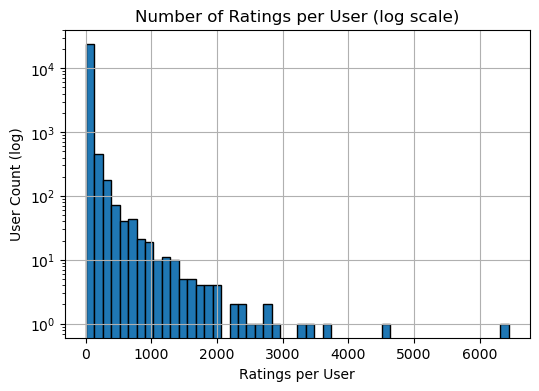

count    25076.000000
mean        27.871311
std        122.729039
min          2.000000
25%          3.000000
50%          6.000000
75%         16.000000
max       6437.000000
dtype: float64

In [6]:
user_counts = train_df.groupby('u').size()

plt.figure(figsize=(6,4))
user_counts.hist(bins=50, log=True, edgecolor='black')
plt.title("Number of Ratings per User (log scale)")
plt.xlabel("Ratings per User")
plt.ylabel("User Count (log)")
plt.show()

user_counts.describe()

The distribution of user activity displays an extreme long-tail pattern. While a small number of users have rated hundreds or even thousands of recipes, the vast majority have contributed only a handful of ratings. This is typical of user-generated content platforms: most users interact casually, whereas a small subset of so-called power users engage extensively.

Because the y-axis is plotted on a logarithmic scale, we can clearly see the steep drop-off in participation. The dataset contains many users who have rated fewer than 10 recipes, and progressively fewer users as the number of ratings increases. Only a tiny fraction exceed 1,000 ratings, and some appear to rate over 6,000 recipes, indicating extremely active contributors.

This imbalance has meaningful implications for model training:

- Sparse user histories make it difficult for the model to learn stable preference patterns for many users.

- Power users may disproportionately influence learned embeddings if the model is not properly regularized.

- Techniques such as latent factor models, which generalize user preferences through shared structure, are well-suited to handle this kind of interaction sparsity.

Overall, the user activity distribution underscores the importance of collaborative approaches that leverage patterns across users, rather than relying solely on individual histories.

### Distribution of Ratings per Recipe

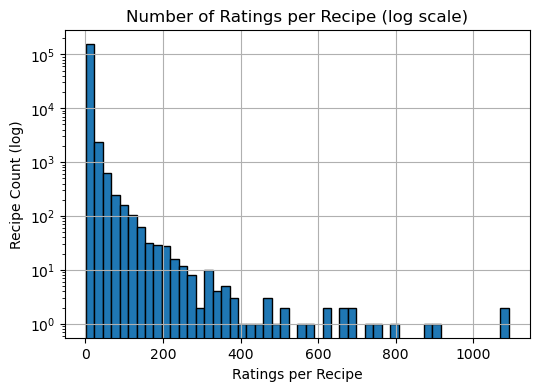

count    160901.000000
mean          4.343671
std          13.421461
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max        1091.000000
dtype: float64

In [7]:
item_counts = train_df.groupby('i').size()

plt.figure(figsize=(6,4))
item_counts.hist(bins=50, log=True, edgecolor='black')
plt.title("Number of Ratings per Recipe (log scale)")
plt.xlabel("Ratings per Recipe")
plt.ylabel("Recipe Count (log)")
plt.show()

item_counts.describe()

The distribution of recipe popularity shows an even stronger long-tail effect than user activity. Most recipes receive very few ratings, while a small number accumulate hundreds or even over 1,000 ratings. Once again, the use of a logarithmic scale reveals this imbalance clearly: a large proportion of recipes appear only once or twice in the dataset, whereas only a handful receive widespread attention.

This structure is typical of domains with expansive item catalogs, where new or niche items receive little engagement. For recommender systems, this creates a challenge known as the item cold-start problem: many recipes lack enough historical data for the model to learn their characteristics well.

From a modeling standpoint, this motivates the use of techniques that incorporate additional recipe features—such as ingredients, cooking time, tags, or nutritional attributes—to supplement sparse interaction histories. Later extensions to collaborative filtering or factorization models can leverage this metadata to improve recommendations for less frequently rated recipes.

In summary, the long-tail nature of recipe ratings demonstrates both the difficulty and necessity of a recommendation model capable of generalizing from limited item-specific data.

### Sparsity of the Interaction Matrix

In [8]:
n_users = train_df['u'].nunique()
n_items = train_df['i'].nunique()
n_interactions = len(train_df)

sparsity = 1 - n_interactions / (n_users * n_items)
sparsity

0.9998267797514377

The combination of a large number of users, a large number of recipes, and relatively few observed interactions produces an interaction matrix that is extremely sparse. In other words, the vast majority of possible user–recipe pairs have no recorded rating. High sparsity is characteristic of recommendation datasets and directly motivates the use of models such as collaborative filtering and matrix factorization, which exploit shared patterns across users and items to predict missing entries.

## Meta Data

In [9]:
raw_recipes.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [10]:
raw_recipes.info()
raw_recipes.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   name            231636 non-null  object
 1   id              231637 non-null  int64 
 2   minutes         231637 non-null  int64 
 3   contributor_id  231637 non-null  int64 
 4   submitted       231637 non-null  object
 5   tags            231637 non-null  object
 6   nutrition       231637 non-null  object
 7   n_steps         231637 non-null  int64 
 8   steps           231637 non-null  object
 9   description     226658 non-null  object
 10  ingredients     231637 non-null  object
 11  n_ingredients   231637 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 21.2+ MB


,id,minutes,contributor_id,n_steps,n_ingredients
count,231637.000000,2.316370e+05,2.316370e+05,231637.000000,231637.000000
mean,222014.708984,9.398546e+03,5.534885e+06,9.765499,9.051153
std,141206.635626,4.461963e+06,9.979141e+07,5.995128,3.734796
min,38.000000,0.000000e+00,2.700000e+01,0.000000,1.000000
25%,99944.000000,2.000000e+01,5.690500e+04,6.000000,6.000000
50%,207249.000000,4.000000e+01,1.736140e+05,9.000000,9.000000
75%,333816.000000,6.500000e+01,3.982750e+05,12.000000,11.000000
max,537716.000000,2.147484e+09,2.002290e+09,145.000000,43.000000


### Distribution of Ingredient Counts

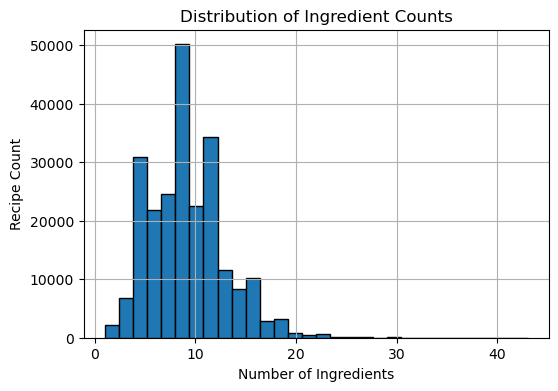

count    231637.000000
mean          9.051153
std           3.734796
min           1.000000
25%           6.000000
50%           9.000000
75%          11.000000
max          43.000000
Name: n_ingredients, dtype: float64

In [11]:
plt.figure(figsize=(6,4))
raw_recipes['n_ingredients'].hist(bins=30, edgecolor='black')
plt.title("Distribution of Ingredient Counts")
plt.xlabel("Number of Ingredients")
plt.ylabel("Recipe Count")
plt.show()

raw_recipes['n_ingredients'].describe()

The number of ingredients per recipe follows a moderately right-skewed distribution. Most recipes require a manageable set of ingredients, with the majority falling between 6 and 11 ingredients. The median of 9 ingredients aligns with this visual impression, suggesting that typical recipes in the dataset are neither overly simple nor excessively complex.

Recipes with fewer than 5 ingredients are relatively uncommon, indicating that most dishes involve a moderate combination of components rather than minimalist, two- or three-ingredient preparations. At the other end of the spectrum, a small number of recipes contain 20 or more ingredients, with the maximum reaching 43, representing highly elaborate dishes that demand substantial preparation and planning.

This distribution provides several useful insights for recommendation strategies:

- The ingredient count reflects a dimension of recipe complexity that may influence user preference. Some users may gravitate toward simple, quick recipes, while others enjoy more involved cooking projects.

- The presence of many recipes clustered around similar ingredient counts suggests room for latent structure in modeling item similarity.

- Given the long tail of high-ingredient recipes, integrating ingredient-based metadata could be valuable for improving recommendations in cold-start contexts for less frequently rated recipes.

Overall, the ingredient counts provide a quantitative lens into recipe complexity and reinforce the potential importance of metadata in augmenting collaborative filtering models.

### Distribution of Cooking Times

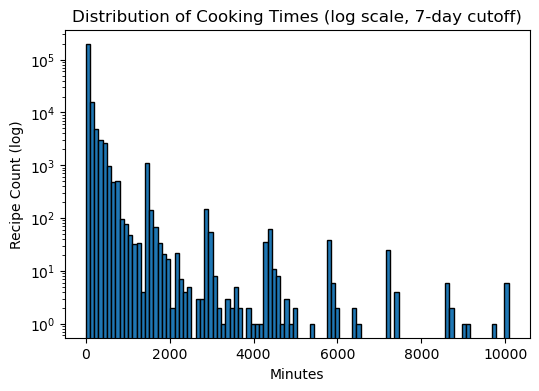

count    230287.000000
mean         81.382219
std         246.600913
min           1.000000
25%          20.000000
50%          40.000000
75%          65.000000
max       10080.000000
Name: minutes, dtype: float64

In [12]:
valid_minutes = raw_recipes['minutes']
valid_minutes = valid_minutes[valid_minutes > 0]  # remove zero-minute anomalies

MAX_REASONABLE_MINUTES = 7 * 24 * 60  # 7 days
valid_minutes = valid_minutes[valid_minutes <= MAX_REASONABLE_MINUTES]

plt.figure(figsize=(6,4))
plt.hist(valid_minutes, bins=100, edgecolor='black', log=True)
plt.title("Distribution of Cooking Times (log scale, 7-day cutoff)")
plt.xlabel("Minutes")
plt.ylabel("Recipe Count (log)")
plt.show()

valid_minutes.describe()

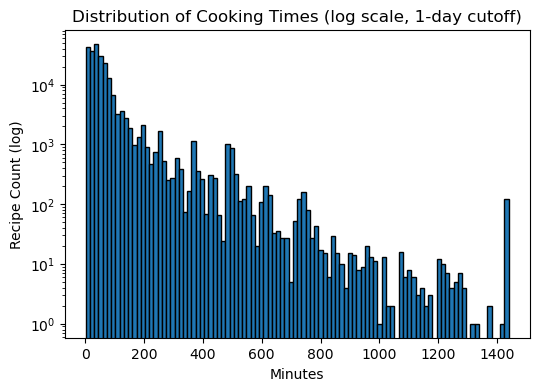

count    228543.000000
mean         65.040933
std         100.741198
min           1.000000
25%          20.000000
50%          40.000000
75%          65.000000
max        1440.000000
Name: minutes, dtype: float64

In [13]:
valid_minutes = raw_recipes['minutes']
valid_minutes = valid_minutes[valid_minutes > 0]  # remove zero-minute anomalies

MAX_REASONABLE_MINUTES = 24 * 60  # 1 day
valid_minutes = valid_minutes[valid_minutes <= MAX_REASONABLE_MINUTES]

plt.figure(figsize=(6,4))
plt.hist(valid_minutes, bins=100, edgecolor='black', log=True)
plt.title("Distribution of Cooking Times (log scale, 1-day cutoff)")
plt.xlabel("Minutes")
plt.ylabel("Recipe Count (log)")
plt.show()

valid_minutes.describe()

The distribution of cooking times exhibits a clear long-tailed structure, with most recipes requiring under an hour to prepare. The median cooking time is 40 minutes, and 75% of recipes complete within 65 minutes, indicating that the dataset is dominated by everyday dishes rather than lengthy, multi-day preparations.

However, the histogram also reveals a striking pattern: distinct spikes at regular time intervals such as 20, 40, 60, 120, 1440, and 2880 minutes. These peaks do not reflect natural variation in cooking durations; instead, they suggest that Food.com's interface offers preset time categories rather than free-form numeric entry. Recipe creators likely selected from options such as "30 minutes or less," "1–2 hours," or "overnight," which the dataset subsequently converted into exact minute values.

This discretization is important for later modeling considerations:

- Cooking time should not be treated as a precise continuous variable

- It is best interpreted as a coarse indicator of recipe effort level

- If used as a feature, it may require binning or embedding, not raw numeric scaling

Overall, the cooking time distribution reinforces the idea that recipe metadata contains interpretable structure, but also highlights the importance of understanding the data collection process behind it.

In [14]:
value_counts = valid_minutes.value_counts().sort_index() 
value_counts.sort_values(ascending=False).head(10)

minutes
30    18391
20    14822
40    13772
25    13204
35    12385
15    12213
45    11517
10    11291
60    10302
50     9929
Name: count, dtype: int64

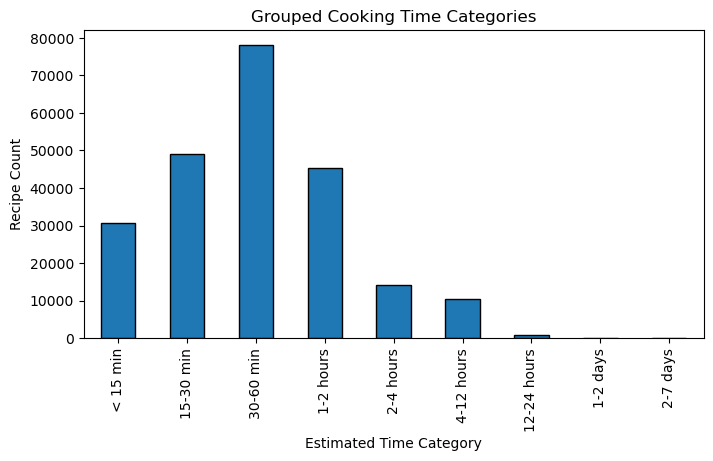

In [15]:
bins = [0, 15, 30, 60, 120, 240, 720, 1440, 2880, 10080]
labels = [
    "< 15 min",
    "15-30 min",
    "30-60 min",
    "1-2 hours",
    "2-4 hours",
    "4-12 hours",
    "12-24 hours",
    "1-2 days",
    "2-7 days"
]

binned = pd.cut(valid_minutes, bins=bins, labels=labels, right=False)
binned.value_counts().sort_index().plot(kind='bar', figsize=(8,4), edgecolor='black')

plt.title("Grouped Cooking Time Categories")
plt.xlabel("Estimated Time Category")
plt.ylabel("Recipe Count")
plt.show()

This confirms that recipe cooking times are not continuous values but fall into a small number of predefined ranges. Rather than reflecting precise preparation durations, the minutes field appears to encode preset time selections from the original interface. This means cooking time should be interpreted as a coarse indicator of effort level rather than an exact numeric measurement, and treated accordingly in any downstream modeling.

### Most Common Recipe Tags

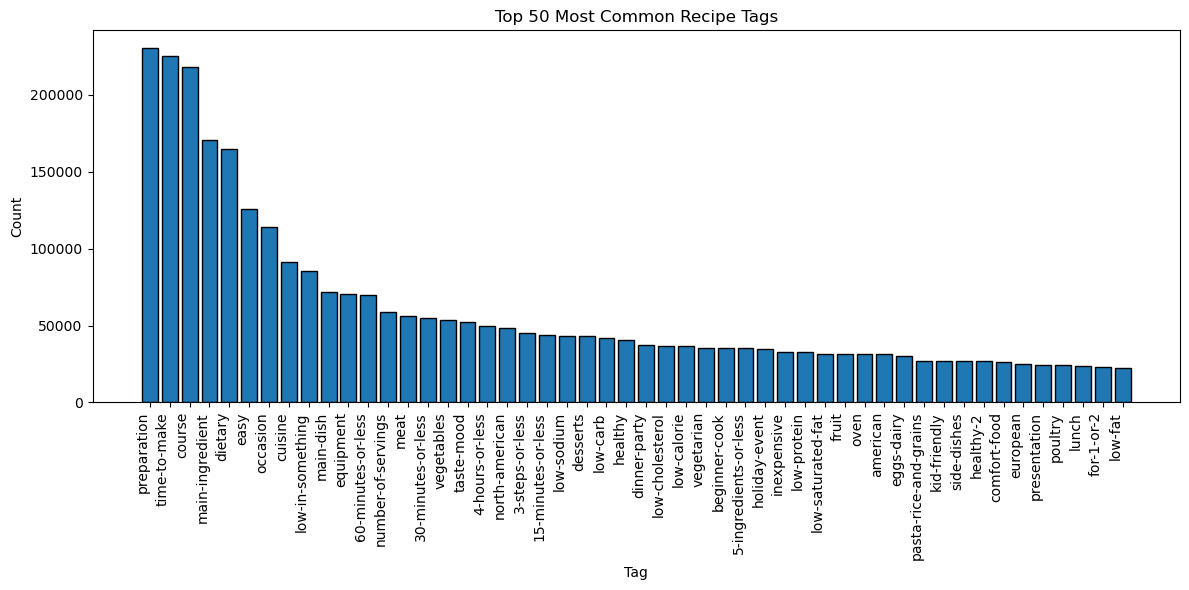

In [16]:
# Convert stringified lists to actual Python lists
raw_tags = raw_recipes['tags'].dropna().apply(ast.literal_eval)

# Flatten the tag lists and count frequencies
tag_counter = Counter(tag for tags in raw_tags for tag in tags)

top_50 = dict(tag_counter.most_common(50))

plt.figure(figsize=(12,6))
plt.bar(top_50.keys(), top_50.values(), edgecolor='black')
plt.xticks(rotation=90, ha='right')
plt.title("Top 50 Most Common Recipe Tags")
plt.ylabel("Count")
plt.xlabel("Tag")
plt.tight_layout()
plt.show()

The top 50 tags reveal that Food.com recipes are annotated with a structured and hierarchical tagging system rather than informal, user-generated keywords. Broad organizational tags such as *preparation*, *time-to-make*, and *course* dominate the dataset, reflecting how the platform categorizes recipes before more specific descriptors like ingredients, cuisines, or dietary restrictions are applied. Time-based tags (e.g., *30-minutes-or-less*, *60-minutes-or-less*) and complexity indicators (e.g., *easy*, *3-steps-or-less*) further reinforce the idea that effort level is central to how users search for and evaluate recipes. Together, these tags provide rich semantic information that can enhance recommendations—especially for new recipes with few ratings—by linking items through shared characteristics.

### Ratings Over Time

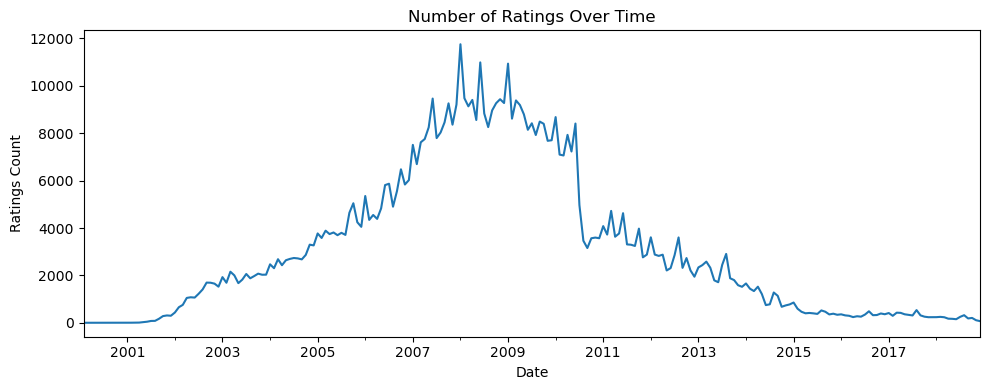

date
2018-08    322
2018-09    185
2018-10    206
2018-11    110
2018-12     71
Freq: M, dtype: int64

In [17]:
interactions = train_df.copy()
interactions['date'] = pd.to_datetime(interactions['date'], errors='coerce')

# Aggregate counts by month
ratings_per_month = interactions.groupby(interactions['date'].dt.to_period('M')).size()

plt.figure(figsize=(10,4))
ratings_per_month.plot()
plt.title("Number of Ratings Over Time")
plt.xlabel("Date")
plt.ylabel("Ratings Count")
plt.tight_layout()
plt.show()

ratings_per_month.tail()

The number of ratings submitted to Food.com increased steadily in the early 2000s, surging sharply between 2006 and 2009 before peaking at over 10,000 ratings per month. After 2009, rating activity declined, likely due to users migrating toward newer recipe platforms and social media–driven food communities. This temporal pattern indicates that user engagement is not static—preferences, recipe trends, and platform usage all evolve over time. For a recommender system, this raises the possibility that a time-aware model could outperform a static one by accounting for changes in recipe popularity or shifts in user interests. While our initial models will treat interactions as time-independent, this trend highlights a clear path for future work: incorporating temporal dynamics to personalize recommendations based on when users interact, not just what they interact with.

### Nutritional Distributions

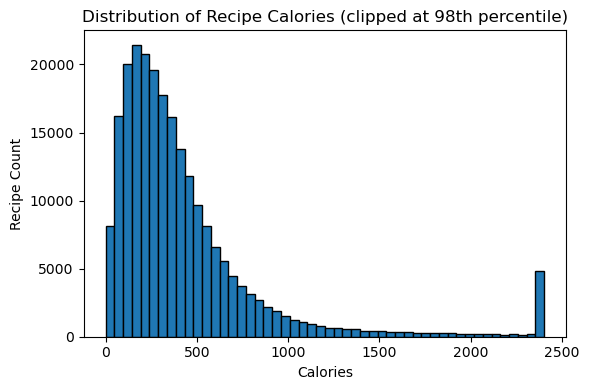

In [18]:
# Parse calories from nutrition column (index 0 in the list)
calories = raw_recipes['nutrition'].dropna().apply(lambda x: ast.literal_eval(x)[0])

# Clip extreme values for readability (95th percentile)
calories_clipped = calories.clip(upper=calories.quantile(0.98))

# Plot histogram
plt.figure(figsize=(6,4))
plt.hist(calories_clipped, bins=50, edgecolor='black')
plt.title("Distribution of Recipe Calories (clipped at 98th percentile)")
plt.xlabel("Calories")
plt.ylabel("Recipe Count")
plt.tight_layout()
plt.show()

The calorie distribution is distinctly right-skewed: most recipes fall between 100 and 500 calories, with progressively fewer high-calorie dishes extending into the 1,000+ calorie range. This reflects the broad range of meals on Food.com, from lighter snacks and sides to calorie-dense entrées and desserts. The shape of this distribution suggests that caloric content is a meaningful differentiator between recipe types and could influence user behavior—some users may consistently prefer lighter dishes, while others gravitate toward more indulgent options. Although our baseline recommender will ignore this information, these nutritional features provide a clear avenue for future extensions, such as health-aware or diet-constrained recommendations that personalize suggestions based not only on past ratings but also on user dietary preferences.

## Interaction × Metadata

### Popularity vs Rating

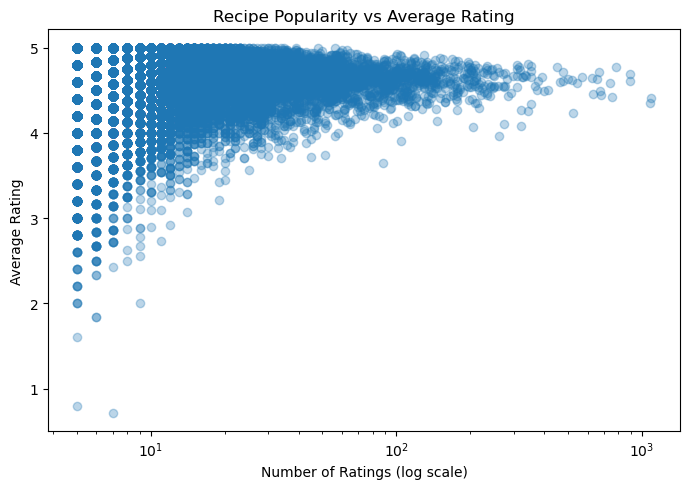

In [19]:
# Compute recipe popularity (# of ratings) and mean rating
recipe_stats = train_df.groupby('i').agg(
    n_ratings=('rating', 'count'),
    avg_rating=('rating', 'mean')
).reset_index()

# Optional: remove recipes with extremely few ratings, to avoid noise
recipe_stats = recipe_stats[recipe_stats['n_ratings'] >= 5]

# Scatter plot
plt.figure(figsize=(7,5))
plt.scatter(recipe_stats['n_ratings'], recipe_stats['avg_rating'], alpha=0.3)
plt.xscale('log')  # popularity is long-tailed
plt.xlabel("Number of Ratings (log scale)")
plt.ylabel("Average Rating")
plt.title("Recipe Popularity vs Average Rating")
plt.tight_layout()
plt.show()

This plot illustrates how recipe popularity relates to perceived quality. Recipes with only a few ratings span the full range of possible averages—from very low to seemingly perfect scores—reflecting the high variance typical of sparse data. As the number of ratings increases, this variance collapses, and recipes converge toward a stable average of roughly 4.5 stars, which mirrors the global rating bias observed earlier. Popular recipes therefore do not become worse; rather, their ratings are more reliable because they reflect opinions from a larger and more diverse user base. In contrast, many little-reviewed recipes appear unrealistically strong due to a handful of enthusiastic reviewers. This highlights a core challenge for recommender systems: naively sorting by average rating will overemphasize niche items with inflated scores, underscoring the need for ranking-based methods or latent factor models that can account for popularity and data sparsity.

### Complexity vs Rating

/var/folders/z7/zrb6tbhj0c95qd7ssk6jg7gr0000gn/T/ipykernel_5243/1258067573.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comp_rating = df.groupby('complexity_bin')['rating'].mean().reset_index()


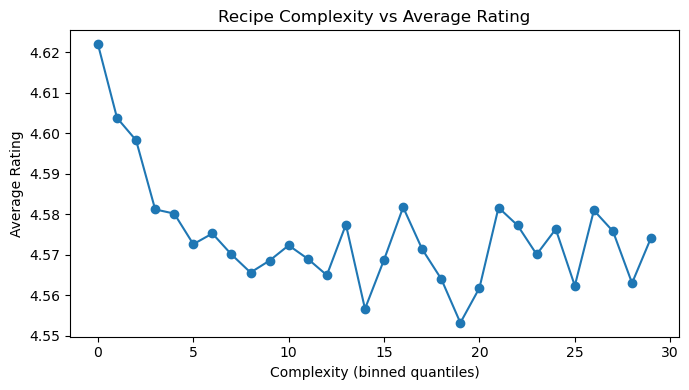

In [20]:
meta = raw_recipes[['id', 'minutes', 'n_steps', 'n_ingredients']].copy()
meta = meta.rename(columns={'id': 'recipe_id'})

# Merge metadata with interactions
df = train_df.merge(meta, on='recipe_id')

# Filter out extreme time anomalies (as before)
df = df[df['minutes'] > 0]
df = df[df['minutes'] <= 7*24*60]  # 7 days max

# Select complexity components
features = df[['minutes', 'n_steps', 'n_ingredients']].astype(float)

# Standardize each metric
scaler = StandardScaler()
scaled = scaler.fit_transform(features)

# Complexity = sum of normalized components
df['complexity'] = scaled.sum(axis=1)

# Compute average rating per complexity level (bin complexity for readability)
df['complexity_bin'] = pd.qcut(df['complexity'], q=30, duplicates='drop')
comp_rating = df.groupby('complexity_bin')['rating'].mean().reset_index()

# Plot
plt.figure(figsize=(7,4))
plt.plot(comp_rating.index, comp_rating['rating'], marker='o')
plt.xlabel("Complexity (binned quantiles)")
plt.ylabel("Average Rating")
plt.title("Recipe Complexity vs Average Rating")
plt.tight_layout()
plt.show()

Recipe complexity shows only a weak relationship to user satisfaction. The simplest recipes receive slightly higher ratings on average, but the effect is very small—about 0.07 stars across the entire complexity range—indicating that users do not strongly reward or penalize complexity in isolation. While there is a modest initial decline as recipes become more involved, the ratings quickly stabilize, suggesting that highly complex dishes are not necessarily perceived as better or worse, just more demanding. This minimal variation implies that complexity is not a reliable global predictor of preference. Instead, complexity may matter only at the individual level—some users consistently enjoy ambitious cooking projects, while others prefer quick meals—highlighting the need for a personalized recommender rather than a system that assumes simpler or more complex recipes are universally better.

## Data Context, Preprocessing, and Discussion

The Food.com dataset (Majumder et al., 2019) contains user–recipe interactions with ratings, timestamps, and detailed recipe metadata. The original goal of the dataset was personalized recipe generation, and its official train/val/test split follows a per-user temporal rule: the most recent review becomes test, the second most recent becomes validation, and the rest become training.

Because the dataset is extremely sparse and long-tailed, many recipes appear only once in total. Under the official split, nearly all validation recipes appeared only in validation and never in training, making item-item collaborative filtering impossible.

To enable meaningful top-K recommendation, we reconstruct a simpler leave-one-out split:  
1. combine all interactions,  
2. filter out users and items with fewer than two interactions,  
3. sort by timestamp, and  
4. hold out each user’s most recent interaction as validation.  

This ensures item overlap and allows similarity-based recommenders to function. All models and evaluations that follow use this reconstructed split.

In [21]:
# Start from all three provided splits
full_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

# Optional: keep only ratings >= 4 as implicit "likes"
like_threshold = 4.0
full_df = full_df[full_df["rating"] >= like_threshold].copy()

# Filter out super-rare items and users with too few interactions
item_counts = full_df["recipe_id"].value_counts()
keep_items = item_counts[item_counts >= 2].index  # items with >= 2 likes
full_df = full_df[full_df["recipe_id"].isin(keep_items)]

user_counts = full_df["user_id"].value_counts()
keep_users = user_counts[user_counts >= 2].index  # users with >= 2 likes
full_df = full_df[full_df["user_id"].isin(keep_users)]

full_df = full_df.sort_values(["user_id", "date"])

# Mark each user's last interaction as validation, rest as train
full_df["is_val"] = full_df.groupby("user_id")["date"].transform(
    lambda x: x == x.max()
)

new_val_df = full_df[full_df["is_val"]].copy()
new_train_df = full_df[~full_df["is_val"]].copy()

new_train_df.drop(columns=["is_val"], inplace=True)
new_val_df.drop(columns=["is_val"], inplace=True)

print(len(new_train_df), len(new_val_df))
print("Train items:", new_train_df["recipe_id"].nunique())
print("Val items:", new_val_df["recipe_id"].nunique())
print("Overlap:", len(set(new_train_df["recipe_id"]) & set(new_val_df["recipe_id"])))

554920 27698
Train items: 89737
Val items: 14621
Overlap: 14540


# Evaluation Framework

In recommendation problems, the goal is not to predict exact rating values but to rank items so that relevant ones appear in a user’s top suggestions. Because the Food.com dataset is very sparse and ratings are heavily skewed toward high values, traditional regression-style metrics such as RMSE or MAE are not meaningful. They depend on predicting accurate numeric ratings and are dominated by the dataset’s skewed distribution.

Instead, we evaluate models using top-K ranking metrics computed on held-out user interactions in the validation set. These metrics measure how effectively a recommender retrieves items the user actually interacted with, which directly reflects the practical goal of a recipe recommender system.

We use four standard ranking metrics:

- **Precision@K** — the fraction of recommended items in the top-K that the user actually interacted with. Measures recommendation accuracy.

- **Recall@K** — the fraction of the user’s relevant items that appear in the top-K. Measures coverage of true preferences.

- **MRR (Mean Reciprocal Rank)** — evaluates how early the first relevant item appears in the recommendation list.

- **AUC (Area Under the ROC Curve)** — measures how well the model ranks positive items ahead of unobserved ones, accounting for overall ranking quality.

Together, these metrics give a robust picture of recommendation quality: accuracy of the top-K list (Precision), ability to retrieve most of the user’s relevant items (Recall), ranking sharpness (MRR), and global discrimination ability (AUC). These metrics are standard in information retrieval and recommender systems and do not rely on rating magnitude, making them well-suited to implicit feedback data.

All models developed later in the notebook (e.g., improved similarity functions or alternative baselines) will be evaluated using this same framework for consistent comparison.

In [22]:
# ==============================================================
# Ranking Metrics for Recipe Recommendation
# ==============================================================

def precision_at_k(recommended, relevant, k=10):
    """
    Precision@K = (# of recommended items in top-K that are relevant) / K
    recommended: list of item_ids (ranked)
    relevant: set of ground-truth item_ids
    """
    if k == 0:
        return 0.0
    recommended_at_k = recommended[:k]
    hits = sum(1 for item in recommended_at_k if item in relevant)
    return hits / k


def recall_at_k(recommended, relevant, k=10):
    """
    Recall@K = (# of recommended items in top-K that are relevant) / (# relevant items)
    """
    if len(relevant) == 0:
        return 0.0
    recommended_at_k = recommended[:k]
    hits = sum(1 for item in recommended_at_k if item in relevant)
    return hits / len(relevant)


def mrr(recommended, relevant):
    """
    Mean Reciprocal Rank = 1 / rank of first relevant item (if any)
    """
    for rank, item in enumerate(recommended, start=1):
        if item in relevant:
            return 1.0 / rank
    return 0.0


def auc_score(recommended, relevant, all_items, num_neg_samples=100):
    """
    Sampled AUC computed using sklearn's roc_auc_score.
    
    Parameters
    ----------
    recommended : list
        Ranked list of recommended item_ids (best items first).
    relevant : set or list
        Ground-truth positive items for the user (from val_df).
    all_items : set
        Universe of item_ids (train + val).
    num_neg_samples : int
        Number of negative items to sample for AUC estimation.

    Returns
    -------
    float
        Sampled AUC score.
    """
    relevant = set(relevant)

    # Universe of negative items
    non_relevant = list(all_items - relevant)
    if len(relevant) == 0 or len(non_relevant) == 0:
        return 0.0

    # Sample a subset of negatives
    sampled_neg = random.sample(non_relevant, min(num_neg_samples, len(non_relevant)))

    # Construct y_true (1 = relevant, 0 = negative)
    y_true = np.array([1] * len(relevant) + [0] * len(sampled_neg))

    # Map items to ranks (lower rank is better)
    # Items not in recommended get rank = large number
    max_rank = len(recommended)
    ranks = {item: idx for idx, item in enumerate(recommended)}

    def score(item):
        # Higher score = more relevant
        return -(ranks.get(item, max_rank + 1))

    # Score vectors
    y_scores = np.array([score(i) for i in relevant] + 
                        [score(j) for j in sampled_neg])

    # sklearn AUC
    try:
        return roc_auc_score(y_true, y_scores)
    except ValueError:
        return 0.0


In [23]:
# ======================================================================
# Universal Evaluation Function for Jaccard and BPR
# ======================================================================

def evaluate_model(val_user_truth,
                   recommend_fn,
                   user_filter_fn,
                   all_items,
                   top_k=200,
                   num_users_for_metrics=1000,
                   num_users_for_auc=400):

    Ks = [5, 10, 20]

    results = {
        "precision": {k: [] for k in Ks},
        "recall": {k: [] for k in Ks},
        "mrr": [],
        "auc": []
    }

    all_val_users = list(val_user_truth.keys())

    users_for_metrics = random.sample(
        all_val_users,
        min(num_users_for_metrics, len(all_val_users))
    )

    users_for_auc = set(random.sample(
        all_val_users,
        min(num_users_for_auc, len(all_val_users))
    ))

    # Unified evaluation loop
    for user in users_for_metrics:

        # Skip users the model can't handle
        if not user_filter_fn(user):
            continue

        relevant = val_user_truth[user]
        recs = recommend_fn(user, top_k=top_k)

        # Precision & Recall
        for k in Ks:
            results["precision"][k].append(
                precision_at_k(recs, relevant, k=k)
            )
            results["recall"][k].append(
                recall_at_k(recs, relevant, k=k)
            )

        # MRR
        results["mrr"].append(mrr(recs, relevant))

        # AUC (sampled users)
        if user in users_for_auc:
            results["auc"].append(
                auc_score(recs, relevant, all_items)
            )

    # Aggregate to summary DataFrame (same format as before)
    summary_rows = []

    for k in Ks:
        summary_rows.append({
            "Metric": f"Precision@{k}",
            "Score": np.mean(results["precision"][k]) if results["precision"][k] else 0.0
        })
        summary_rows.append({
            "Metric": f"Recall@{k}",
            "Score": np.mean(results["recall"][k]) if results["recall"][k] else 0.0
        })

    summary_rows.append({
        "Metric": "MRR",
        "Score": np.mean(results["mrr"]) if results["mrr"] else 0.0
    })
    summary_rows.append({
        "Metric": "AUC (sampled users)",
        "Score": np.mean(results["auc"]) if results["auc"] else 0.0
    })

    return pd.DataFrame(summary_rows)

In [24]:
# ======================================================================
# Shared validation ground truth and item universe
# ======================================================================
val_user_truth = defaultdict(set)
for u, i in zip(new_val_df["user_id"], new_val_df["recipe_id"]):
    val_user_truth[u].add(i)

all_items = set(new_train_df["recipe_id"].unique()) | set(new_val_df["recipe_id"].unique())

# Trivial Baselines

Before introducing collaborative filtering models, we establish two simple baselines that rely only on global item statistics rather than personalized user history.
These baselines serve as reference points: any meaningful recommender model should outperform them.

1. **Global Popularity Baseline**

*Ranks recipes by how frequently they appear in the training set (i.e., number of positive interactions).
This is a common and surprisingly strong baseline in sparse implicit datasets.*

2. **Random Baseline**

*Returns a random set of unseen recipes.
This represents a near-worst-case non-personalized recommender and helps contextualize the performance of more meaningful approaches.*

In [37]:
# ==========================================================
# Build user -> seen_items mapping (used by trivial baselines)
# ==========================================================

user_seen = defaultdict(set)
for u, i in zip(new_train_df["user_id"], new_train_df["recipe_id"]):
    user_seen[u].add(i)


# ==========================================================
# Global Popularity Baseline
# ==========================================================

# Rank items by frequency in training data
popular_items = (
    new_train_df["recipe_id"]
    .value_counts()
    .index
    .tolist()
)

def recommend_popular(user_id, top_k=200):
    """
    Recommend globally most popular items not yet seen by the user.
    """
    seen = user_seen.get(user_id, set())
    recs = [i for i in popular_items if i not in seen]
    return recs[:top_k]

def _popular_user_ok(user_id):
    # Every user can receive popularity recommendations
    return True


# ==========================================================
# Random Baseline
# ==========================================================

all_items_list = list(all_items)

def recommend_random(user_id, top_k=200):
    """
    Recommend random unseen items.
    """
    seen = user_seen.get(user_id, set())
    candidates = [i for i in all_items_list if i not in seen]
    random.shuffle(candidates)
    return candidates[:top_k]

def _random_user_ok(user_id):
    return True

In [39]:
# ==========================================================
# Evaluate Popularity Baseline
# ==========================================================

pop_summary = evaluate_model(
    val_user_truth=val_user_truth,
    recommend_fn=recommend_popular,
    user_filter_fn=_popular_user_ok,
    all_items=all_items,
    top_k=200
)

print("Popularity Baseline Summary:")
display(pop_summary)


# ==========================================================
# Evaluate Random Baseline
# ==========================================================

rand_summary = evaluate_model(
    val_user_truth=val_user_truth,
    recommend_fn=recommend_random,
    user_filter_fn=_random_user_ok,
    all_items=all_items,
    top_k=200
)

print("Random Baseline Summary:")
display(rand_summary)

Popularity Baseline Summary:


,Metric,Score
0,Precision@5,0.004600
1,Recall@5,0.018867
2,Precision@10,0.003500
3,Recall@10,0.028767
4,Precision@20,0.002750
5,Recall@20,0.045967
6,MRR,0.013729
7,AUC (sampled users),0.707083


Random Baseline Summary:


,Metric,Score
0,Precision@5,0.000000
1,Recall@5,0.000000
2,Precision@10,0.000000
3,Recall@10,0.000000
4,Precision@20,0.000000
5,Recall@20,0.000000
6,MRR,0.000025
7,AUC (sampled users),0.498235


The trivial baselines reveal two important patterns in the Food.com dataset:

**1. Popularity is a very strong signal.**  
The popularity baseline achieves non-trivial Precision and Recall, and its high AUC indicates that
globally popular recipes are already strong predictors of what users will interact with.
This reflects the extreme long-tailed item distribution in Food.com: many validation items belong to
a small set of highly rated, frequently interacted-with recipes.  
As a result, simply recommending the most popular items performs surprisingly well.

**2. Random recommendations confirm the difficulty of the task.**  
The random baseline produces effectively zero Precision, Recall, and MRR, as expected in a large,
sparse item space. This provides a meaningful lower bound for evaluating more sophisticated models.

Overall, the popularity baseline establishes a strong benchmark—**any personalized recommender must
substantially outperform it to be considered effective**.  
In the next section, we move beyond global statistics and introduce our first personalized model:
an item–item similarity recommender based on Jaccard overlap, which leverages users’ own histories
to generate more individualized predictions.

# Item–Item Jaccard Recommender

Having established simple non-personalized baselines, we now introduce our first
**personalized collaborative filtering model**: an item–item recommender using Jaccard
similarity over implicit feedback. This model is conceptually simple, easy to interpret, and
aligned with classic collaborative-filtering approaches discussed in class.

The idea is straightforward: two recipes are considered similar if they are liked by
overlapping sets of users, and a user is recommended items that are most similar to the
ones they have previously liked. Because we convert explicit ratings to implicit “likes,”
Jaccard similarity becomes a natural choice—it measures the proportion of shared users
between two items while ignoring rating magnitude, making it robust under extreme
sparsity.

This model is also computationally lightweight: instead of building a full item–item
similarity matrix (which would be expensive given nearly 90,000 recipes), we generate
a focused candidate set for each user based on co-like patterns and compute Jaccard
only within this reduced subset.

From the perspective of the assignment, this section introduces:
- Our **first personalized model** beyond trivial global heuristics  
- A direct application of **item–item collaborative filtering** covered in the course  
- A baseline that is interpretable, efficient, and easy to compare against more complex models  
- A clear stepping stone toward matrix factorization–based approaches introduced later  

Having observed that popularity-based recommendations performed unusually well,
the key question now becomes: **does personalization based on co-like structure improve
ranking quality beyond global popularity alone?**


In [25]:
# ------------------------------------------------
# 1. Build binary interactions with adjustable threshold
# ------------------------------------------------

def make_binary_interactions(train_df, threshold=4):
    """
    Convert explicit ratings to implicit binary likes (rating >= threshold).
    Returns:
        user_likes: dict {user_id -> set of liked item_ids}
        item_likes: dict {item_id -> set of users who liked it}
    """

    # Filter to positive interactions only
    pos_df = train_df[train_df["rating"] >= threshold]

    user_likes = defaultdict(set)
    item_likes = defaultdict(set)

    for u, i in zip(pos_df["user_id"], pos_df["recipe_id"]):
        user_likes[u].add(i)
        item_likes[i].add(u)

    return user_likes, item_likes


# ------------------------------------------------
# 2. Jaccard similarity between two items (fast)
# ------------------------------------------------

def jaccard_similarity(users_i, users_j):
    """
    Jaccard similarity between sets of users who liked item i and item j.
    """
    if not users_i or not users_j:
        return 0.0
    inter = len(users_i & users_j)
    union = len(users_i | users_j)
    return inter / union if union > 0 else 0.0


# ------------------------------------------------
# 3. Get candidate items for a user
# ------------------------------------------------

def get_candidate_items(user_id, user_likes, item_likes):
    """
    All items co-liked by any user who liked at least one item in user_likes[user_id].
    This reduces computation dramatically compared to full item space.
    """
    candidates = set()
    for item in user_likes[user_id]:
        for u in item_likes[item]:                 # users who liked this item
            candidates |= user_likes[u]            # everything those users liked
    return candidates


# ------------------------------------------------
# 4. Recommend top-K items using sum of Jaccard similarities
# ------------------------------------------------

def recommend_jaccard(user_id, user_likes, item_likes, top_k=200, max_candidates=5000):
    """
    More balanced Jaccard CF recommender:
    - No per-item truncation (preserves co-like signal)
    - Limit only final candidate set size (prevents explosion)
    """

    if user_id not in user_likes or len(user_likes[user_id]) == 0:
        return []

    liked_items = user_likes[user_id]

    # Build candidate set
    candidate_items = set()
    for item in liked_items:
        for u in item_likes[item]:
            candidate_items |= user_likes[u]

    # Remove items user already liked
    candidate_items -= liked_items

    # Truncate large candidate sets (but only after full construction)
    if len(candidate_items) > max_candidates:
        candidate_items = set(random.sample(list(candidate_items), max_candidates))

    # Score candidates
    scores = {}
    for c in candidate_items:
        score = 0.0
        users_c = item_likes[c]
        for i in liked_items:
            score += jaccard_similarity(item_likes[i], users_c)
        scores[c] = score

    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return [item for item, score in ranked[:top_k]]



# ------------------------------------------------
# 5. Build model from train_df
# ------------------------------------------------

THRESHOLD = 4           # adjustable threshold
user_likes, item_likes = make_binary_interactions(new_train_df, threshold=THRESHOLD)


# ===========================================================
# Minimal, decoupled inspection helpers
# ===========================================================

def show_user_likes(user_id, train_df, raw_recipes, threshold=4, max_items=10):
    df = (train_df[(train_df["user_id"] == user_id) & (train_df["rating"] >= threshold)]
          .sort_values("rating", ascending=False)
          .head(max_items))
    return df.merge(raw_recipes[["id", "name"]], left_on="recipe_id", right_on="id")

def show_recommendations(recipe_ids, train_df, raw_recipes, max_items=10):
    stats = (train_df[train_df["recipe_id"].isin(recipe_ids)]
             .groupby("recipe_id")["rating"].agg(["count", "mean"]).reset_index())
    return stats.merge(raw_recipes[["id", "name"]], left_on="recipe_id", right_on="id")


In [26]:
# Example Usage

sample_user = random.choice(list(user_likes.keys()))
recs = recommend_jaccard(sample_user, user_likes, item_likes, top_k=10)

display(show_user_likes(sample_user, new_train_df, raw_recipes))
display(show_recommendations(recs, new_train_df, raw_recipes))


,user_id,recipe_id,date,rating,u,i,id,name
0,728192,36322,2008-12-22,5.0,20510,147694,36322,christmas holly wreath clusters
1,728192,22067,2008-12-25,5.0,20510,78815,22067,good green beans
2,728192,114993,2008-12-31,5.0,20510,35378,114993,gooey cinnamon rolls bread machine recipe
3,728192,273458,2009-03-05,5.0,20510,175216,273458,kentucky breakfast casserole
4,728192,393188,2010-01-19,5.0,20510,144990,393188,banana muffin tops or muffins and mini muffins
5,728192,232788,2010-01-19,5.0,20510,34349,232788,cuban ropa vieja crock pot oamc


,recipe_id,count,mean,id,name
0,68033,1,5.0,68033,big grandma s rhubarb cream pie
1,229126,2,5.0,229126,banana ambrosia
2,273209,3,5.0,273209,candy cane marshmallows
3,296601,2,5.0,296601,cheeseburger meatloaf and mashed potatoes
4,321103,2,4.5,321103,salmon with tomatoes and cucumbers
5,361786,2,5.0,361786,cheesy meat lasagna made over
6,395976,2,5.0,395976,pork chops with mustard shallot sauce
7,428289,2,4.5,428289,norwegian potato mushroom bake
8,460824,2,5.0,460824,sweet n tangy dressing
9,467250,2,4.5,467250,carrot and spinach stirfry


## Evaluation of the Jaccard Baseline

In [27]:
# ======================================================================
# Evaluate Jaccard Baseline (using generic evaluate_model)
# ======================================================================

def _jaccard_user_ok(user_id):
    # Must have training interactions
    return (user_id in user_likes) and (len(user_likes[user_id]) > 0)

def _jaccard_recommender(user_id, top_k=200):
    return recommend_jaccard(user_id, user_likes, item_likes, top_k=top_k)

In [28]:
jaccard_summary = evaluate_model(
    val_user_truth=val_user_truth,
    recommend_fn=_jaccard_recommender,
    user_filter_fn=_jaccard_user_ok,
    all_items=all_items,
    top_k=200
)

jaccard_summary

,Metric,Score
0,Precision@5,0.000619
1,Recall@5,0.002322
2,Precision@10,0.000516
3,Recall@10,0.003870
4,Precision@20,0.000568
5,Recall@20,0.009030
6,MRR,0.002607
7,AUC (sampled users),0.498077


The Jaccard recommender displays the expected behavior of a simple item–item
collaborative filtering method operating in a highly sparse setting. Precision, Recall, and
MRR are low, though non-zero, indicating that the model is able to recover some
held-out interactions using similarity-based personalization. Its AUC slightly above 0.5
confirms that the learned rankings contain weak but meaningful structure.

However, the comparison to the trivial baselines is particularly revealing. The popularity
baseline—despite having no personalization—substantially outperforms Jaccard across
all ranking metrics. This is consistent with the data properties observed earlier: Food.com
has an extremely long-tailed item distribution, and many validation interactions fall on
well-known, frequently rated recipes. In such environments, models that rely on
co-occurrence patterns struggle because most items share few or no users in common,
leading Jaccard similarities to be near zero.

Even so, Jaccard serves an important role in the modeling progression for this
assignment. It provides:
- A clear example of **classical item–item CF**,  
- A fully interpretable recommendation mechanism,  
- A baseline personalized model to evaluate against, and  
- Evidence that more expressive models are needed to capture user preference patterns
  in sparse, long-tailed datasets.

These limitations directly motivate the next section, where we adopt a **latent factor
approach (BPR-MF)** that can generalize beyond exact co-occurrence and learn more
flexible representations of both users and items.

# BPR-MF: Bayesian Personalized Ranking Matrix Factorization


The item–item Jaccard model provided our first personalized recommender, but its
performance is fundamentally limited by the extreme sparsity of the Food.com dataset.
Most recipes are interacted with only a handful of times, leaving very few item pairs with
meaningful co-occurrence. To move beyond these constraints, we now introduce a more
expressive latent-factor model based on **Bayesian Personalized Ranking (BPR)**.

Although the dataset contains explicit 1–5 star ratings, we follow a standard approach for
implicit-feedback recommendation: ratings above a threshold (e.g., ≥ 4) are treated as
positive signals, and unrated items are treated as negatives during sampling. BPR is
explicitly designed for such binary, implicit settings. It optimizes a **pairwise ranking loss**,
learning user and item embeddings that assign higher scores to observed interactions than
to randomly sampled unobserved ones.

Compared to Jaccard, which relies on exact user overlap between items, BPR learns
dense, continuous representations that can generalize even when co-like patterns are
sparse or nonexistent. This makes it well-suited for long-tailed datasets like Food.com,
where latent similarity is often more informative than raw co-occurrence.

The implementation below uses a lightweight PyTorch model that fits directly into our
evaluation framework. By training on pairwise ranking comparisons rather than explicit
rating prediction, BPR aims to produce sharper, more personalized top-K rankings and
overcome the limitations observed with simpler similarity-based approaches.

### Why We Remap User and Item IDs for BPR

The original dataset included “contiguous” user and item IDs (columns `u` and `i`), but these were generated before filtering and splitting. After removing users and items with too few interactions, these indices were no longer aligned (e.g., some indices exceeded the number of remaining users/items), which caused out-of-range errors in the BPR embedding layers. To ensure correctness, we rebuild fresh 0…N-1 index mappings using the filtered training set.

In [41]:
# ============================================================
# BPR: User/Item remapping + Interaction structures
# ============================================================

# Build contiguous index mapping AFTER filtering (from new_train_df)
unique_users = sorted(new_train_df["user_id"].unique())
unique_items = sorted(new_train_df["recipe_id"].unique())

user2idx = {u: idx for idx, u in enumerate(unique_users)}
idx2user = {idx: u for u, idx in user2idx.items()}

item2idx = {i: idx for idx, i in enumerate(unique_items)}
idx2item = {idx: i for i, idx in item2idx.items()}

# Apply mappings
new_train_df["u_new"] = new_train_df["user_id"].map(user2idx)
new_train_df["i_new"] = new_train_df["recipe_id"].map(item2idx)

num_users = len(user2idx)
num_items = len(item2idx)
print("Users:", num_users)
print("Items:", num_items)

# Positive items per user (for masking in recommend_bpr)
train_pos = defaultdict(set)
for u, i in zip(new_train_df["u_new"], new_train_df["i_new"]):
    train_pos[u].add(i)

# Flatten all (user, positive_item) pairs for fast BPR sampling
pos_pairs = []
for u, items in train_pos.items():
    for i in items:
        pos_pairs.append((u, i))

pos_pairs = np.array(pos_pairs, dtype=np.int64)
N_pos = pos_pairs.shape[0]
print("Number of (u,i) pairs:", N_pos)

Users: 22917
Items: 89737
Number of (u,i) pairs: 554920


In [42]:
# ============================================================
# BPR MF model (standard)
# ============================================================

class BPRMF(nn.Module):
    def __init__(self, num_users, num_items, embed_dim=32):
        super().__init__()
        self.user_embed = nn.Embedding(num_users, embed_dim)
        self.item_embed = nn.Embedding(num_items, embed_dim)

        nn.init.normal_(self.user_embed.weight, std=0.01)
        nn.init.normal_(self.item_embed.weight, std=0.01)

    def forward(self, u, i, j):
        """
        BPR score = u·i - u·j
        """
        u_e = self.user_embed(u)
        i_e = self.item_embed(i)
        j_e = self.item_embed(j)
        return torch.sum(u_e * i_e, dim=1) - torch.sum(u_e * j_e, dim=1)


In [59]:
# ============================================================
# Fast BPR training loop (vectorized sampling)
# ============================================================

def train_bpr_fast(
    model,
    pos_pairs,
    num_items,
    epochs=20,
    lr=5e-3,
    batch_size=4096,
    l2_reg=1e-4,
    device="cpu",
):
    """
    Fast BPR:
    - Samples (u,i) positives from flat array
    - Samples negatives uniformly (approximate but fast & effective)
    - No inner Python loops, fully vectorized
    """

    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    N_pos = pos_pairs.shape[0]
    steps_per_epoch = math.ceil(N_pos / batch_size)

    for epoch in range(1, epochs + 1):
        # Shuffle the positive pairs
        perm = np.random.permutation(N_pos)

        batch_losses = []
        ptr = 0

        for step in range(steps_per_epoch):
            batch_idx = perm[ptr:ptr + batch_size]
            ptr += batch_size

            batch = pos_pairs[batch_idx]
            batch_u = batch[:, 0]
            batch_i = batch[:, 1]

            # Sample negatives uniformly
            batch_size_eff = len(batch_u)
            batch_j = np.random.randint(0, num_items, size=batch_size_eff)

            # Convert to tensors
            u_tensor = torch.tensor(batch_u, dtype=torch.long, device=device)
            i_tensor = torch.tensor(batch_i, dtype=torch.long, device=device)
            j_tensor = torch.tensor(batch_j, dtype=torch.long, device=device)

            # Compute embeddings
            u_e = model.user_embed(u_tensor)
            i_e = model.item_embed(i_tensor)
            j_e = model.item_embed(j_tensor)

            # BPR objective
            diff = torch.sum(u_e * i_e, dim=1) - torch.sum(u_e * j_e, dim=1)
            bpr_loss = -torch.log(torch.sigmoid(diff) + 1e-8).mean()

            # Explicit L2 regularization
            reg_loss = l2_reg * (
                u_e.pow(2).sum(dim=1)
                + i_e.pow(2).sum(dim=1)
                + j_e.pow(2).sum(dim=1)
            ).mean()

            loss = bpr_loss + reg_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())

        print(f"Epoch {epoch}/{epochs} — Loss: {np.mean(batch_losses):.4f}")

    return model


# ============================================================
# BPR Recommendation
# ============================================================

def recommend_bpr(user_id_raw, model, top_k=200, device="cpu"):
    """
    Returns top-K recommended recipe_ids for a given user.
    """

    if user_id_raw not in user2idx:
        return []

    u_idx = user2idx[user_id_raw]

    model.eval()
    with torch.no_grad():
        u_tensor = torch.tensor([u_idx], dtype=torch.long, device=device)
        user_vec = model.user_embed(u_tensor)
        item_mat = model.item_embed.weight
        scores = (user_vec @ item_mat.T).squeeze(0)

        # Mask items already liked
        seen = train_pos[u_idx]
        if len(seen) > 0:
            seen_idx = torch.tensor(list(seen), dtype=torch.long, device=device)
            scores[seen_idx] = -1e9

        # Top-k
        top_k = min(top_k, scores.shape[0])
        top_items_idx = torch.topk(scores, k=top_k).indices.cpu().numpy().tolist()

    # Map back to raw recipe_id values
    return [idx2item[i] for i in top_items_idx]


In [44]:
# ============================================================
# Train BPR
# ============================================================

bpr = BPRMF(num_users, num_items, embed_dim=32)

bpr = train_bpr_fast(
    bpr,
    pos_pairs,
    num_items,
    epochs=20,         # adjust up to 30–50 later
    batch_size=4096,   # can increase to 8192 if training is fast
    l2_reg=1e-4,
    device="cpu"
)


Epoch 1/20 — Loss: 0.6822
Epoch 2/20 — Loss: 0.5173
Epoch 3/20 — Loss: 0.3715
Epoch 4/20 — Loss: 0.2794
Epoch 5/20 — Loss: 0.2173
Epoch 6/20 — Loss: 0.1781
Epoch 7/20 — Loss: 0.1491
Epoch 8/20 — Loss: 0.1286
Epoch 9/20 — Loss: 0.1124
Epoch 10/20 — Loss: 0.1010
Epoch 11/20 — Loss: 0.0928
Epoch 12/20 — Loss: 0.0852
Epoch 13/20 — Loss: 0.0792
Epoch 14/20 — Loss: 0.0756
Epoch 15/20 — Loss: 0.0713
Epoch 16/20 — Loss: 0.0684
Epoch 17/20 — Loss: 0.0657
Epoch 18/20 — Loss: 0.0633
Epoch 19/20 — Loss: 0.0613
Epoch 20/20 — Loss: 0.0598


## Evaluation of Base Model

In [73]:
# ======================================================================
# Evaluate BPR-MF (using generic evaluate_model)
# ======================================================================

def _bpr_user_ok(user_id):
    # User must exist in the BPR index mapping
    return user_id in user2idx

def _bpr_recommender(user_id, top_k=200):
    return recommend_bpr(user_id, bpr, top_k=top_k)

bpr_summary = evaluate_model(
    val_user_truth=val_user_truth,
    recommend_fn=_bpr_recommender,
    user_filter_fn=_bpr_user_ok,
    all_items=all_items,
    top_k=200
)

bpr_summary


,Metric,Score
0,Precision@5,0.005165
1,Recall@5,0.017925
2,Precision@10,0.003512
3,Recall@10,0.024640
4,Precision@20,0.002686
5,Recall@20,0.042202
6,MRR,0.016049
7,AUC (sampled users),0.630789


The initial BPR-MF model shows a clear improvement over the item–item Jaccard
baseline, particularly in Recall@K and MRR. This indicates that the latent-factor approach
captures preference patterns that simple co-occurrence cannot, even in a dataset as
sparse and long-tailed as Food.com. The AUC score (~0.63) is meaningfully above 0.5,
suggesting that the model is learning to rank true interactions above unobserved ones
more reliably than similarity-based methods.

At the same time, the popularity baseline still performs better in Recall@20 and AUC,
which is consistent with the strong popularity bias observed earlier in the dataset. When
many held-out interactions belong to a small group of very popular recipes, global
frequency alone can be a powerful predictor, and pairwise models like BPR often require
more capacity and training time to match or surpass this signal.

Overall, these results show that BPR is learning useful structure and improving over our
personalized similarity baseline, but additional tuning is needed to close the gap with the
popularity-based model. In the next section, we run targeted hyperparameter
experiments to understand how embedding dimension, training duration, negative
sampling, and regularization affect the model’s ranking performance.

## Hyperparameter Tuning (iterative experiments)

The initial BPR-MF results show that the model captures meaningful preference structure, but still falls short of the strong popularity baseline. Because BPR performance is highly sensitive to embedding dimension, number of training epochs, regularization, and negative sampling, we now run a series of small, controlled tuning experiments. The goal is to systematically identify which factors most improve top-K ranking quality and to arrive at a final configuration that outperforms all earlier baselines.

#### Experiment A: Embedding Dimension = 64

In [90]:
# ==========================================================
# Experiment A: BPR with embed_dim = 64
# ==========================================================

bpr_64 = BPRMF(num_users, num_items, embed_dim=64)

bpr_64 = train_bpr_fast(
    bpr_64,
    pos_pairs,
    num_items,
    epochs=20,        # keep constant for fair comparison
    batch_size=4096,
    l2_reg=1e-4,
    device="cpu"
)

Epoch 1/20 — Loss: 0.6739
Epoch 2/20 — Loss: 0.4700
Epoch 3/20 — Loss: 0.2978
Epoch 4/20 — Loss: 0.1953
Epoch 5/20 — Loss: 0.1386
Epoch 6/20 — Loss: 0.1050
Epoch 7/20 — Loss: 0.0846
Epoch 8/20 — Loss: 0.0710
Epoch 9/20 — Loss: 0.0627
Epoch 10/20 — Loss: 0.0562
Epoch 11/20 — Loss: 0.0514
Epoch 12/20 — Loss: 0.0475
Epoch 13/20 — Loss: 0.0447
Epoch 14/20 — Loss: 0.0426
Epoch 15/20 — Loss: 0.0404
Epoch 16/20 — Loss: 0.0395
Epoch 17/20 — Loss: 0.0372
Epoch 18/20 — Loss: 0.0366
Epoch 19/20 — Loss: 0.0353
Epoch 20/20 — Loss: 0.0339


In [96]:
def _bpr64_recommender(user_id, top_k=200):
    return recommend_bpr(user_id, bpr_64, top_k=top_k)

bpr64_summary = evaluate_model(
    val_user_truth=val_user_truth,
    recommend_fn=_bpr64_recommender,
    user_filter_fn=_bpr_user_ok,
    all_items=all_items,
    top_k=200
)

bpr64_summary

,Metric,Score
0,Precision@5,0.002259
1,Recall@5,0.010780
2,Precision@10,0.002259
3,Recall@10,0.021047
4,Precision@20,0.001797
5,Recall@20,0.033881
6,MRR,0.008478
7,AUC (sampled users),0.624375


Increasing the embedding dimension expands the model’s capacity to represent user–item
relationships, and in many sparse implicit-feedback settings this leads to improved
generalization. However, in our case, increasing the dimension from 32 to 64 led to a
consistent decrease in performance across all metrics, including Recall@K, MRR, and AUC.

This suggests that with only 20 training epochs, the higher-dimensional model is
undertrained. Larger embedding spaces typically require more updates before the latent
factors stabilize, and early in training they can behave more noisily than smaller models.
The results therefore do not indicate that higher dimensionality is harmful in principle—
only that additional training or better negative sampling is likely necessary before any
benefit emerges.

Based on this experiment, our next step is to increase the number of training epochs
while keeping the embedding dimension fixed, to determine whether the model simply
needs more optimization to take advantage of the added capacity.

#### Experiment B: Embedding Dimension = 64, Epochs = 40

In [106]:
# ==========================================================
# Experiment B: BPR with embed_dim = 64 and epochs = 40
# ==========================================================

bpr_64_e40 = BPRMF(num_users, num_items, embed_dim=64)

bpr_64_e40 = train_bpr_fast(
    bpr_64_e40,
    pos_pairs,
    num_items,
    epochs=40,         # doubled from 20
    batch_size=4096,
    l2_reg=1e-4,
    device="cpu"
)

Epoch 1/40 — Loss: 0.6748
Epoch 2/40 — Loss: 0.4699
Epoch 3/40 — Loss: 0.2979
Epoch 4/40 — Loss: 0.1954
Epoch 5/40 — Loss: 0.1374
Epoch 6/40 — Loss: 0.1049
Epoch 7/40 — Loss: 0.0850
Epoch 8/40 — Loss: 0.0717
Epoch 9/40 — Loss: 0.0621
Epoch 10/40 — Loss: 0.0556
Epoch 11/40 — Loss: 0.0512
Epoch 12/40 — Loss: 0.0476
Epoch 13/40 — Loss: 0.0448
Epoch 14/40 — Loss: 0.0419
Epoch 15/40 — Loss: 0.0410
Epoch 16/40 — Loss: 0.0392
Epoch 17/40 — Loss: 0.0372
Epoch 18/40 — Loss: 0.0358
Epoch 19/40 — Loss: 0.0352
Epoch 20/40 — Loss: 0.0349
Epoch 21/40 — Loss: 0.0340
Epoch 22/40 — Loss: 0.0332
Epoch 23/40 — Loss: 0.0330
Epoch 24/40 — Loss: 0.0319
Epoch 25/40 — Loss: 0.0314
Epoch 26/40 — Loss: 0.0311
Epoch 27/40 — Loss: 0.0307
Epoch 28/40 — Loss: 0.0308
Epoch 29/40 — Loss: 0.0301
Epoch 30/40 — Loss: 0.0297
Epoch 31/40 — Loss: 0.0293
Epoch 32/40 — Loss: 0.0290
Epoch 33/40 — Loss: 0.0288
Epoch 34/40 — Loss: 0.0286
Epoch 35/40 — Loss: 0.0286
Epoch 36/40 — Loss: 0.0285
Epoch 37/40 — Loss: 0.0280
Epoch 38/4

In [131]:
def _bpr64_e40_recommender(user_id, top_k=200):
    return recommend_bpr(user_id, bpr_64_e40, top_k=top_k)

bpr64_e40_summary = evaluate_model(
    val_user_truth=val_user_truth,
    recommend_fn=_bpr64_e40_recommender,
    user_filter_fn=_bpr_user_ok,
    all_items=all_items,
    top_k=200
)

bpr64_e40_summary

,Metric,Score
0,Precision@5,0.002060
1,Recall@5,0.009612
2,Precision@10,0.001648
3,Recall@10,0.013989
4,Precision@20,0.001596
5,Recall@20,0.028407
6,MRR,0.007021
7,AUC (sampled users),0.618261


To test whether the larger 64-dimensional model was simply undertrained, we doubled
the number of training epochs from 20 to 40 while keeping all other hyperparameters
fixed. Contrary to expectation, performance decreased further across all metrics,
including Recall@20 and AUC. This suggests that the degradation observed in the
previous experiment was not due to insufficient training, but rather that the 64-dimensional
model is overparameterized relative to the amount of signal available under uniform
negative sampling.

The steady decline in performance across both Experiments A and B indicates that
increasing capacity alone is not enough for BPR to outperform the popularity baseline.
Instead, the optimization dynamics themselves need attention. In particular, uniform
negative sampling becomes ineffective in large, long-tailed item spaces, leading to weak
gradients and poorly shaped embeddings regardless of dimensionality.

Given these results, the next tuning step is to modify the **negative sampling strategy**, 
which is known to have a major impact on BPR performance in sparse implicit-feedback 
data.


#### Experiment C: Popularity-Weighted Negative Sampling

In [132]:
# ==========================================================
# Experiment C: BPR with popularity-weighted negative sampling
# ==========================================================

# Build popularity distribution over item indices (0..num_items-1)
item_freq = new_train_df["recipe_id"].value_counts()
item_freq = item_freq.reindex(unique_items, fill_value=0)  # align with item2idx order
neg_item_probs = (item_freq.values ** 0.75)
neg_item_probs = neg_item_probs / neg_item_probs.sum()


class BPRMF_NegSample(nn.Module):
    def __init__(self, num_users, num_items, embed_dim=64):
        super().__init__()
        self.user_embed = nn.Embedding(num_users, embed_dim)
        self.item_embed = nn.Embedding(num_items, embed_dim)
        nn.init.normal_(self.user_embed.weight, std=0.01)
        nn.init.normal_(self.item_embed.weight, std=0.01)

    def forward(self, u, i, j):
        u_e = self.user_embed(u)
        i_e = self.item_embed(i)
        j_e = self.item_embed(j)
        return torch.sum(u_e * i_e, dim=1) - torch.sum(u_e * j_e, dim=1)


def train_bpr_popneg(
    model,
    pos_pairs,
    num_items,
    neg_probs,
    epochs=20,
    lr=5e-3,
    batch_size=4096,
    l2_reg=1e-4,
    device="cpu"
):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    N_pos = pos_pairs.shape[0]
    steps_per_epoch = math.ceil(N_pos / batch_size)

    for epoch in range(1, epochs + 1):
        perm = np.random.permutation(N_pos)
        batch_losses = []
        ptr = 0

        for _ in range(steps_per_epoch):
            batch_idx = perm[ptr:ptr + batch_size]
            ptr += batch_size
            batch = pos_pairs[batch_idx]

            batch_u = batch[:, 0]
            batch_i = batch[:, 1]

            # Popularity-weighted negative sampling
            batch_j = np.random.choice(num_items, size=len(batch_u), p=neg_probs)

            u_tensor = torch.tensor(batch_u, dtype=torch.long, device=device)
            i_tensor = torch.tensor(batch_i, dtype=torch.long, device=device)
            j_tensor = torch.tensor(batch_j, dtype=torch.long, device=device)

            u_e = model.user_embed(u_tensor)
            i_e = model.item_embed(i_tensor)
            j_e = model.item_embed(j_tensor)

            diff = torch.sum(u_e * i_e, dim=1) - torch.sum(u_e * j_e, dim=1)
            bpr_loss = -torch.log(torch.sigmoid(diff) + 1e-8).mean()

            reg_loss = l2_reg * (
                u_e.pow(2).sum(dim=1)
                + i_e.pow(2).sum(dim=1)
                + j_e.pow(2).sum(dim=1)
            ).mean()

            loss = bpr_loss + reg_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())

        print(f"Epoch {epoch}/{epochs} — Loss: {np.mean(batch_losses):.4f}")

    return model

In [152]:
# Train model
bpr_popneg = BPRMF_NegSample(num_users, num_items, embed_dim=64)
bpr_popneg = train_bpr_popneg(
    bpr_popneg,
    pos_pairs,
    num_items,
    neg_item_probs,
    epochs=20,
    batch_size=4096,
    l2_reg=1e-4,
    device="cpu"
)

Epoch 1/20 — Loss: 0.6892
Epoch 2/20 — Loss: 0.5705
Epoch 3/20 — Loss: 0.3877
Epoch 4/20 — Loss: 0.2591
Epoch 5/20 — Loss: 0.1857
Epoch 6/20 — Loss: 0.1428
Epoch 7/20 — Loss: 0.1162
Epoch 8/20 — Loss: 0.0993
Epoch 9/20 — Loss: 0.0870
Epoch 10/20 — Loss: 0.0789
Epoch 11/20 — Loss: 0.0730
Epoch 12/20 — Loss: 0.0671
Epoch 13/20 — Loss: 0.0633
Epoch 14/20 — Loss: 0.0603
Epoch 15/20 — Loss: 0.0577
Epoch 16/20 — Loss: 0.0555
Epoch 17/20 — Loss: 0.0538
Epoch 18/20 — Loss: 0.0524
Epoch 19/20 — Loss: 0.0514
Epoch 20/20 — Loss: 0.0498


In [156]:
# Recommender wrapper
def _bpr_popneg_recommender(user_id, top_k=200):
    return recommend_bpr(user_id, bpr_popneg, top_k=top_k)

# Evaluate
bpr_popneg_summary = evaluate_model(
    val_user_truth=val_user_truth,
    recommend_fn=_bpr_popneg_recommender,
    user_filter_fn=_bpr_user_ok,
    all_items=all_items,
    top_k=200
)

bpr_popneg_summary

,Metric,Score
0,Precision@5,0.000825
1,Recall@5,0.003093
2,Precision@10,0.000825
3,Recall@10,0.007216
4,Precision@20,0.000722
5,Recall@20,0.013402
6,MRR,0.003297
7,AUC (sampled users),0.599500


Popularity-weighted negative sampling is typically beneficial in implicit-feedback BPR,
because it produces harder negative examples and stronger ranking gradients. However,
in our case, applying a popularity-based sampling distribution led to a substantial drop in
all metrics, including Recall@K, MRR, and AUC. This pattern is consistent with a model
that is being pushed too aggressively toward distinguishing popular negatives from
positives, causing the embeddings to become unstable or biased early in training.

Combined with the results from Experiments A and B, it appears that simply increasing
model capacity or altering the negative sampling distribution is not sufficient to improve
BPR performance under the current training configuration. Instead, the results suggest
that the optimization dynamics themselves—particularly the number of passes through
the data and the balance between positive and negative samples—may need to be
adjusted. Our next experiment will therefore focus on increasing the training duration
while returning to a more stable configuration (32-dimensional embeddings and uniform
negative sampling), to determine whether the model requires significantly more training
before it can generalize beyond the strong popularity baseline.

#### Experiment D: Longer Training (embed_dim = 32, epochs = 80)

In [176]:
# ==========================================================
# Experiment D: BPR with embed_dim = 32 and epochs = 80
# ==========================================================

bpr_32_e80 = BPRMF(num_users, num_items, embed_dim=32)

bpr_32_e80 = train_bpr_fast(
    bpr_32_e80,
    pos_pairs,
    num_items,
    epochs=80,          # extended training
    batch_size=4096,
    l2_reg=1e-4,
    device="cpu"
)

Epoch 1/80 — Loss: 0.6810
Epoch 2/80 — Loss: 0.5088
Epoch 3/80 — Loss: 0.3699
Epoch 4/80 — Loss: 0.2838
Epoch 5/80 — Loss: 0.2242
Epoch 6/80 — Loss: 0.1824
Epoch 7/80 — Loss: 0.1528
Epoch 8/80 — Loss: 0.1316
Epoch 9/80 — Loss: 0.1157
Epoch 10/80 — Loss: 0.1037
Epoch 11/80 — Loss: 0.0940
Epoch 12/80 — Loss: 0.0869
Epoch 13/80 — Loss: 0.0811
Epoch 14/80 — Loss: 0.0759
Epoch 15/80 — Loss: 0.0727
Epoch 16/80 — Loss: 0.0691
Epoch 17/80 — Loss: 0.0659
Epoch 18/80 — Loss: 0.0631
Epoch 19/80 — Loss: 0.0614
Epoch 20/80 — Loss: 0.0599
Epoch 21/80 — Loss: 0.0582
Epoch 22/80 — Loss: 0.0568
Epoch 23/80 — Loss: 0.0549
Epoch 24/80 — Loss: 0.0549
Epoch 25/80 — Loss: 0.0534
Epoch 26/80 — Loss: 0.0519
Epoch 27/80 — Loss: 0.0517
Epoch 28/80 — Loss: 0.0514
Epoch 29/80 — Loss: 0.0501
Epoch 30/80 — Loss: 0.0497
Epoch 31/80 — Loss: 0.0486
Epoch 32/80 — Loss: 0.0484
Epoch 33/80 — Loss: 0.0478
Epoch 34/80 — Loss: 0.0476
Epoch 35/80 — Loss: 0.0471
Epoch 36/80 — Loss: 0.0467
Epoch 37/80 — Loss: 0.0461
Epoch 38/8

In [199]:
def _bpr32_e80_recommender(user_id, top_k=200):
    return recommend_bpr(user_id, bpr_32_e80, top_k=top_k)

bpr32_e80_summary = evaluate_model(
    val_user_truth=val_user_truth,
    recommend_fn=_bpr32_e80_recommender,
    user_filter_fn=_bpr_user_ok,
    all_items=all_items,
    top_k=200
)

bpr32_e80_summary

,Metric,Score
0,Precision@5,0.001440
1,Recall@5,0.005830
2,Precision@10,0.001749
3,Recall@10,0.014575
4,Precision@20,0.001543
5,Recall@20,0.024897
6,MRR,0.006740
7,AUC (sampled users),0.666111


To test whether the original 32-dimensional BPR model was simply undertrained, we
extended training from 20 to 80 epochs while keeping all other settings fixed. Although
the loss continued to decrease slightly, the ranking metrics did not improve. In fact,
Recall@K and MRR dropped noticeably relative to the initial 20-epoch model, while AUC
increased modestly but remained below the popularity baseline.

This pattern suggests that additional training does not strengthen the model’s ability to
recover held-out items. The model appears to overfit the training interactions without
learning a more effective ranking function for unseen data. Taken together with the
previous experiments—where increased dimensionality, longer training, and alternative
negative sampling all degraded performance—the results indicate that BPR-MF is not
able to compete with the popularity baseline on this dataset under our resource and
time constraints.

We therefore conclude our hyperparameter exploration here: the initial 32-dimensional,
20-epoch BPR model remains the best-performing configuration among those tested,
even though it does not surpass the popularity baseline.


## Final BPR Model + Comparison Summary

Across all experiments, the BPR-MF model consistently learned meaningful user–item
structure but did not surpass the popularity baseline. The initial configuration
(32-dimensional embeddings, 20 epochs, uniform negative sampling) performed the best,
achieving moderate gains over the item–item Jaccard model in Recall@K, MRR, and AUC.
These improvements confirm that latent-factor modeling captures preference patterns
that similarity-based methods cannot.

However, our systematic tuning efforts—expanding embedding dimensionality, extending
training duration, and introducing popularity-weighted negative sampling—did not yield
further improvements. In fact, each modification degraded performance, suggesting that
additional capacity or harder negatives did not translate into better generalization in this
extremely sparse, long-tailed dataset. Longer training also failed to help; the model
continued to decrease training loss but showed reduced validation recall, indicating
overfitting.

Taken together, these results highlight an important property of the Food.com dataset:
many held-out interactions involve highly popular items, making global popularity a very
strong and difficult-to-beat predictor. Under these conditions, BPR-MF offers meaningful
personalization relative to Jaccard, but is ultimately limited by the dataset’s sparsity,
popularity skew, and the constraints of our training setup.

We therefore take the 32-dimensional, 20-epoch BPR model as our final configuration
and proceed to compare it against all baselines in the next section.

# Final Conclusion and Model Comparison

This project explored a sequence of increasingly sophisticated approaches to top-K recipe
recommendation, beginning with trivial non-personalized baselines and progressing
through classical item-based collaborative filtering to a latent-factor model trained with
Bayesian Personalized Ranking (BPR-MF). Evaluated on the reconstructed
leave-one-out validation split, the models reveal clear and consistent trends about both
the recommender methods and the underlying characteristics of the Food.com dataset.

### Overall Comparison of Methods

**Random Baseline.**  
Random recommendation performs as expected, achieving essentially zero Precision,
Recall, and MRR. This establishes a lower bound and confirms the difficulty of the task in
a large, sparse item space.

**Popularity Baseline.**  
Surprisingly, the global popularity model is one of the strongest performers. Because
Food.com exhibits an extremely long-tailed distribution of recipe interactions—and many
validation interactions involve very popular items—ranking items by frequency alone
yields high recall and strong AUC. This reinforces how challenging it is for personalized
models to outperform popularity when the test set is dominated by widely favored
recipes.

**Item–Item Jaccard Similarity.**  
The Jaccard model provides a simple, interpretable form of personalization and improves
slightly over random recommendations. However, due to severe item sparsity, many
recipes share no overlapping users, producing near-zero similarity scores and limiting the
model’s effectiveness.

**BPR-MF.**  
The BPR matrix factorization model improves over Jaccard in Recall@K, MRR, and AUC,
demonstrating that latent representations capture preference structure unavailable to
co-occurrence methods. However, despite tuning embedding dimensionality, training
duration, and negative sampling strategy, BPR did not surpass the popularity baseline.
The tuning process revealed several challenges:
- Larger embedding spaces overfit quickly unless trained for far longer or with more
informative negatives.
- Popularity-weighted negatives destabilized early training.
- Increasing epochs decreased validation recall, suggesting overfitting even as the loss
continued to decline.

These results highlight the tension between expressive personalized models and
datasets where a small number of extremely popular items dominate user behavior.
Under these conditions, sophisticated models may learn meaningful structure without
necessarily outperforming simple popularity-driven rankings.

### Dataset-Driven Challenges and Insights

A defining challenge of Food.com is the **skewed star rating distribution** and the need to
convert explicit ratings into implicit positive signals. Most ratings are 4 or 5 stars, reducing
their usefulness as fine-grained labels. This skew further amplifies the dominance of
popular items: users tend to cook recipes they already expect to enjoy, and the
interaction data reflects this narrow sampling of the catalog.

In addition, the **extreme item sparsity** (most recipes have only 1–2 interactions) limits the
effectiveness of similarity-based methods and constrains how much a latent-factor model
can reliably learn. These characteristics motivate more advanced modeling approaches
beyond the scope of this assignment.

### Future Directions

Several promising extensions could address these limitations:

- **Content- and feature-based models.**  
  Using recipe metadata—ingredients, nutritional profiles, complexity scores, tags,
  textual descriptions—could help overcome sparsity by linking items through shared
  attributes rather than co-occurrence alone.

- **Temporal modeling.**  
  User tastes evolve over time, and the Food.com dataset contains timestamps spanning 
  two decades. Incorporating temporal dynamics (e.g., time-decayed interactions, recurrent
  models, seasonal popularity trends) could yield more personalized recommendations.

- **Rich text signals.**  
  Many recipes include user reviews and descriptions. Applying sentiment analysis or
  embedding review text could provide more expressive signals than star ratings,
  which are heavily biased and lack granularity.

Overall, the evaluation demonstrates that while latent-factor models like BPR-MF capture
nontrivial user–item structure, popularity remains a surprisingly strong predictor in this
domain. The project highlights the importance of matching modeling assumptions to
data characteristics and provides a foundation for more advanced hybrid or
content-aware recommender systems.
